# Machine Learning Stuff
Kinda just for fun. Seeing if I can predict the wallet report response with some machine learning techniques.

I used all the variables I had access to: the field experiment variables, the survey measures, the economic/institutional performance measures, the PISA scores. I couldn't get anything to yield a better accuracy than about 0.7. This makes sense because it would be crazy if you could actually predict how honest someone would be at any given time with such little information.

In [60]:
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
pio.renderers.default = "sphinx_gallery"

import seaborn as sns

# Do we really need this?
from pandas.api.types import is_numeric_dtype

import numpy as np

from scipy.stats import chi2_contingency

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

# Data import
survey_cols = [
    "general_trust",
    "GPS_trust",
    "general_morality",
    "MFQ_genmorality",
    "civic_cooperation",
    "GPS_posrecip",
    "GPS_altruism",
    "stranger1",
]

cat_cols = [
    "male",
    "above40",
    "computer",
    "coworkers",
    "other_bystanders",
    "institution",
    "cond",
    "security_cam",
    "security_guard",
    "local_recipient",
    "no_english",
    "understood_situation",
]

econ_cols = [
    "log_gdp",
    "log_tfp",
    "gee",
    "letter_grading",
]

# Import Tannenbaum data
df = pd.read_csv(
    "../data/tannenbaum_data.csv",
    dtype={col: "category" for col in cat_cols + ["country", "response"]},
)

# Import PISA data
pisa = pd.read_csv("../data/pisa_data.csv")
pisa = pisa.loc[pisa['year'] == 2015]
pisa = pisa.groupby('country')['pisa_score'].mean().reset_index()
df = df.merge(pisa, how="left", on="country")

## Exploratory Data Analysis (EDA)

Visualizing the distributions of individual features and their relationships.

### Feature Distributions

Histograms for continuous variables and bar plots for categorical variables.

In [ ]:
def subplot_subset(data_frame, cols_to_plot, n_subplot_cols=4):
    """Make a grid of histograms or bar plots for specified columns."""
    if data_frame.empty or not cols_to_plot:
        print("Dataframe is empty or no columns to plot.")
        return

    n_features = len(cols_to_plot)
    n_rows = (
        n_features + n_subplot_cols - 1
    ) // n_subplot_cols  # Calculate number of rows needed

    fig = make_subplots(rows=n_rows, cols=n_subplot_cols, subplot_titles=cols_to_plot)

    for i, feature in enumerate(cols_to_plot):
        row_idx = (i // n_subplot_cols) + 1
        col_idx = (i % n_subplot_cols) + 1

        if pd.api.types.is_numeric_dtype(data_frame[feature]):
            fig.add_trace(
                go.Histogram(x=data_frame[feature], name=feature),
                row=row_idx,
                col=col_idx,
            )
        else:  # Categorical
            # For bar plots, we need counts of each category
            counts = data_frame[feature].value_counts()
            fig.add_trace(
                go.Bar(x=counts.index, y=counts.values, name=feature),
                row=row_idx,
                col=col_idx,
            )

    fig.update_layout(
        title_text="Feature Distributions", height=300 * n_rows, showlegend=False
    )
    fig.show()

print("Displaying distributions for wallet reporting rates and PISA scores:")
subplot_subset(df, ["response", "pisa_score"])

print("Displaying distributions for survey measures:")
subplot_subset(df, survey_cols)

print("\nDisplaying distributions for categorical features:")
subplot_subset(df, cat_cols)

print("\nDisplaying distributions for economic/institutional performance measures:")
subplot_subset(df, econ_cols)

Displaying distributions for survey measures:


Displaying distributions for survey measures:



Displaying distributions for categorical features:



Displaying distributions for economic/institutional performance measures:


### Generalized Association Matrix
To understand relationships between pairs of variables, we compute a generalized correlation matrix. This uses Pearson's correlation for numeric-numeric pairs, correlation ratio for numeric-categorical pairs, and Cramer's V for categorical-categorical pairs.

In [62]:
def cramers_v(ex, y_cramer):
    """Cramer correlation between two categorical variables."""
    # Ensure no NaN values, as crosstab will not handle them well for chi2
    ex_nona = ex.dropna()
    y_cramer_nona = y_cramer.dropna()
    # Align indices if they are different after dropping NaNs
    common_index = ex_nona.index.intersection(y_cramer_nona.index)
    ex_nona = ex_nona.loc[common_index]
    y_cramer_nona = y_cramer_nona.loc[common_index]
    
    if ex_nona.empty or y_cramer_nona.empty:
        return 0.0 # Or np.nan if preferred for empty inputs
        
    confusion_matrix = pd.crosstab(ex_nona, y_cramer_nona)
    if confusion_matrix.empty or confusion_matrix.shape[0] == 0 or confusion_matrix.shape[1] == 0:
        return 0.0
        
    chi2_cramers = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    if n == 0:
        return 0.0
        
    phi2 = chi2_cramers / n
    r, k = confusion_matrix.shape
    if min(k - 1, r - 1) == 0:
        return 0.0 # Avoid division by zero if a variable has only one category after filtering
    return np.sqrt(phi2 / min(k - 1, r - 1))

def correlation_ratio(values, categories):
    """Correlation ratio between a categorical and numeric variable."""
    na_mask = values.notna() & categories.notna()
    num_var = values[na_mask]
    cat_var = categories[na_mask]

    if num_var.empty or cat_var.empty or len(cat_var.unique()) < 2:
        return 0.0

    fcat, _ = pd.factorize(cat_var)
    cat_num = np.max(fcat) + 1
    y_avg = num_var.mean()

    numerator = sum(
        len(num_var[fcat == i]) * (num_var[fcat == i].mean() - y_avg) ** 2
        for i in range(cat_num) if len(num_var[fcat == i]) > 0
    )
    denominator = np.sum((num_var - y_avg) ** 2)

    return np.sqrt(numerator / denominator) if denominator != 0 else 0.0

df_cols_assoc = df.columns.drop("country")
assoc = pd.DataFrame(index=df_cols_assoc, columns=df_cols_assoc, dtype=float)

for col1 in df_cols_assoc:
    for col2 in df_cols_assoc:
        if col1 == col2:
            assoc.loc[col1, col2] = 1.0
        elif is_numeric_dtype(df[col1]) and is_numeric_dtype(df[col2]):
            # Both numeric:
            corr_val = df[[col1, col2]].corr().iloc[0, 1]
            assoc.loc[col1, col2] = corr_val if pd.notna(corr_val) else 0.0
        elif is_numeric_dtype(df[col1]) and not is_numeric_dtype(df[col2]):
            # First numeric, second categorical:
            assoc.loc[col1, col2] = correlation_ratio(df[col1], df[col2])
        elif is_numeric_dtype(df[col2]) and not is_numeric_dtype(df[col1]):
            # First categorical, second numeric:
            assoc.loc[col1, col2] = correlation_ratio(df[col2], df[col1])
        else:
            # Both categorical:
            assoc.loc[col1, col2] = cramers_v(df[col1], df[col2])

assoc = assoc.astype(float)

fig_assoc = px.imshow(
    assoc,
    labels=dict(x="Features", y="Features", color="Association"),
    color_continuous_scale="RdBu_r",
    zmin=-1,
    zmax=1,
    aspect="auto",
)
fig_assoc.update_layout(title_text="Association Matrix (Generalized Correlation)", height=800)
fig_assoc.show()

### Pairplot for Numeric Features and Response
Visualizing relationships between numeric features, colored by the 'response' variable.

Displaying pairplot for numeric features, colored by response category.


Text(0.5, 1.02, 'Pairplot of Numeric Features by Wallet Response')

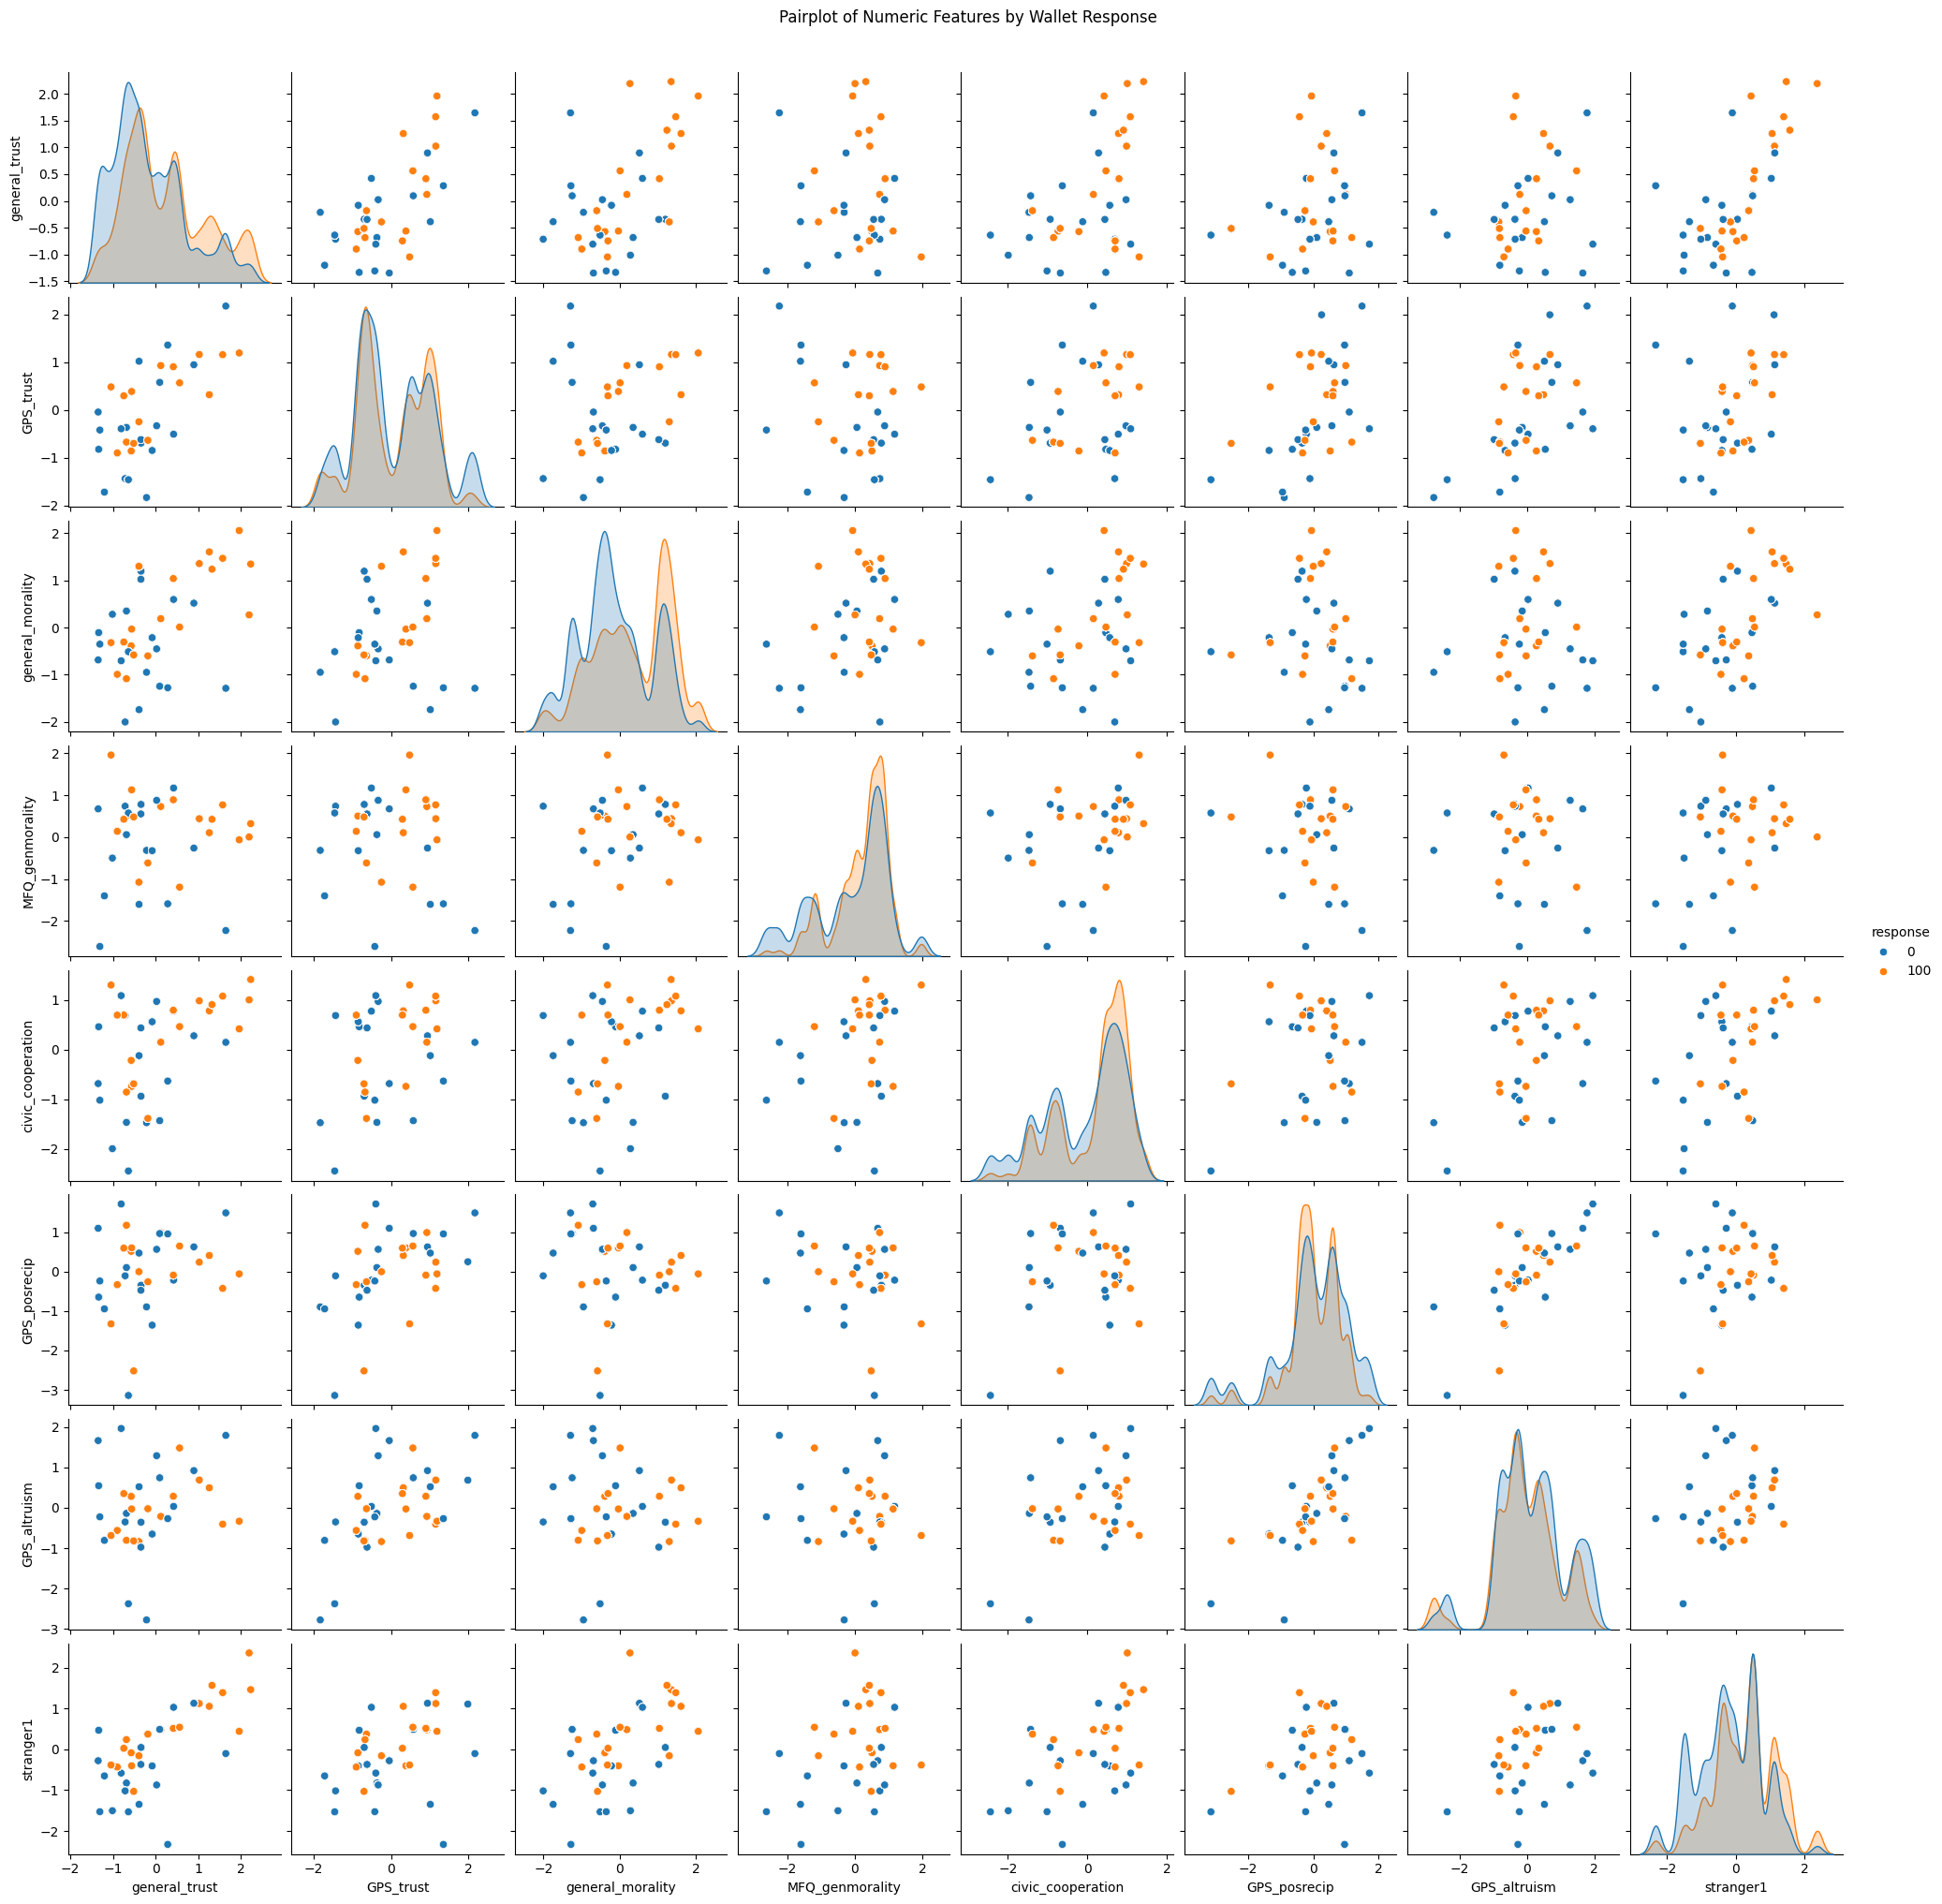

In [66]:
# Ensure 'response' is suitable for hue (categorical)
df_pairplot = df.copy()
if pd.api.types.is_numeric_dtype(df_pairplot["response"]):
    df_pairplot["response"] = df_pairplot["response"].astype(str)

print("Displaying pairplot for numeric features, colored by response category.")
pairplot_fig = sns.pairplot(
    df_pairplot[survey_cols + ["response"]], hue="response", diag_kind="kde"
)

# pairplot_fig.fig.suptitle("Pairplot of Numeric Features by Wallet Response", y=1.02)

## Predicting Wallet Response

Building models to predict whether a wallet is reported based on various features. We'll first use the original features, then incorporate PISA scores to see if they improve predictive accuracy (at an individual prediction level, which is a different task than country-level prediction/correlation).

### Prediction model without PISA data

In [42]:
# Define features for this model
numeric_features_ml1 = survey_cols
categorical_features_ml1 = cat_cols

# Numeric feature pipeline
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# Categorical feature pipeline
categorical_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="most_frequent"),
        ),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        # SelectPercentile for categorical features after OHE might be 
        # less common than for numeric.
        # Chi2 requires non-negative features, which OHE provides.
        # ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor1 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_ml1),
        ("cat", categorical_transformer, categorical_features_ml1),
    ]
)

# Target variable:
# 'response' categories are '0' and '100'. We map them to 0 and 1 with .cat.codes
y = df["response"].cat.codes
X = df.drop(columns="response")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=12,
    stratify=y,  # Stratify by y for classification
)


# Classifier pipeline.
clf1 = Pipeline(
    steps=[
        ("preprocessor", preprocessor1),
        # ("classifier", SVC(random_state=123, class_weight="balanced")),
        # ("classifier", KNeighborsClassifier(n_neighbors=50))
        ("classifier", LogisticRegression(max_iter=10000, random_state=123))
        # ("classifier", RidgeClassifier(alpha=5))
        # ("classifier", GaussianNB())
        # ("classifier", tree.DecisionTreeClassifier())
        # ("classifier", RandomForestClassifier(class_weight='balanced', random_state=43)),
        # could try xgboost,
    ]
)

# Weighting observations. This was an experiment; its effectiveness can vary.
weight_cols = ["security_guard", "no_english", "coworkers"]
cond_counts = X_train[weight_cols].value_counts(normalize=True)
weights = X_train[weight_cols].apply(
    lambda row: 1 / cond_counts.get(tuple(row), 1.0), axis=1
)

clf1.fit(X_train, y_train, classifier__sample_weight=weights)
score1 = clf1.score(X_test, y_test)
print(f"Model 1 (without PISA) score: {score1:.3f}")

########################################################################
# XGBOOST
########################################################################

# Transform the training and test data
X_train_transformed = preprocessor1.transform(X_train)
X_test_transformed = preprocessor1.transform(X_test)

from xgboost import XGBClassifier

model = XGBClassifier(max_depth=40, learning_rate=0.11, objective="binary:logistic")
model.fit(X_train_transformed, y_train)
preds = model.predict(X_test_transformed)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, preds)
print(f"Accuracy with XGBoost: {accuracy:.3f}")

Model 1 (without PISA) score: 0.679
Accuracy with XGBoost: 0.647


### Prediction model with PISA data (and other SC measures)
Here, we add country-level PISA scores and other social capital measures (`econ_cols`) to the feature set. Note that PISA scores are country-level, so they will be constant for all individuals within the same country. This will almost certainly limit their predictive power for individual responses but is included cause why not.

In [59]:
# Impute PISA scores if some countries in df don't have them.
df["pisa_score"] = df["pisa_score"].fillna(df["pisa_score"].mean())

numeric_features_ml2 = ["pisa_score"] + econ_cols + survey_cols

# Categorical features
categorical_features_ml2 = cat_cols

# Numeric transformer (can reuse the previous one if strategy is the same)
numeric_transformer_ml2 = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

# Categorical transformer (can reuse)
categorical_transformer_ml2 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        # ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_ml2, numeric_features_ml2),
        ("cat", categorical_transformer_ml2, categorical_features_ml2),
    ],
    remainder="drop",
)

# Target variable
y2 = df["response"].cat.codes
X2 = df.drop(columns="response")

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=23, stratify=y2
)

clf2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor2),
        # ("classifier", SVC(random_state=123, class_weight="balanced")),
        # ("classifier", tree.DecisionTreeClassifier()),
        (
            "classifier",
            RandomForestClassifier(
                max_depth=10, random_state=0, class_weight="balanced"
            ),
        ),
    ]
)

# If using weights
# Weighting (optional, as before)
cond_counts2 = X_train2["cond"].value_counts(normalize=True)
weights2 = X_train2["cond"].map(lambda x: 1 / cond_counts2[x] if x in cond_counts2 else 1.0)
clf2.fit(X_train2, y_train2, classifier__sample_weight=weights2)

# clf2.fit(X_train2, y_train2)
score2 = clf2.score(X_test2, y_test2)
print(f"Model 2 (with PISA & SC measures) score: {score2:.3f}")

Model 2 (with PISA & SC measures) score: 0.687


### Commentary on Machine Learning Results

Using a comprehensive set of variables (experiment variables, survey measures, economic/institutional performance measures, PISA scores), the predictive accuracy for individual wallet responses did not dramatically improve, typically hovering around 0.68 - 0.70 (depending on the model, parameters, and specific run).

This level of accuracy is somewhat expected. Predicting individual acts of honesty with high precision based on available (mostly demographic or country-level) data is inherently challenging. Individual behavior is complex and influenced by many factors not captured in these datasets.

At the **country level**, wallet return rates (and PISA scores) show predictive power for various economic and institutional indicators (as explored by Tannenbaum and extended here with PISA in regressions). However, at the **individual level**, predicting whether a specific person will return a wallet based on the available features (even including PISA scores as a country-level proxy) remains difficult. This highlights the difference between aggregate societal trends and individual behavior prediction.